In [5]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import plotly.express as px
from pathlib import Path
import json
from pathlib import Path
import geopandas as gpd

import sys

In [7]:
root_folder = Path.cwd().parent. parent
geo_folder = Path(root_folder).joinpath('data',  'external',  'RegionsShapefiles')

sys.path.append(str(root_folder))

files = list(Path(geo_folder).glob('*'))

from src.data.task_1_food_security.dataset import Dataset

In [8]:
ds = Dataset(root_folder=root_folder)
ds.prepare_dataset_array()
units = ds.code2unit()

In [9]:
unit_names = units['adm2_name'].values

unit_dict = {'type': 'FeatureCollection', 'features': []}

for file in files:
    loaded_name = str(file).split('/')[-1].split('.')[0]
    unit_name = ds.match_unit(loaded_name, unit_names)
    unit_code = units[units['adm2_name'] == unit_name]['code'].values[0]
    with open(file) as f:
        loaded_feature = json.load(f)
    if len(loaded_feature['features']) > 1:
        print("More than one feature. Stopping...")
        break
    loaded_feature = loaded_feature['features'][0]
    loaded_feature['properties']['NAME'] = unit_name
    loaded_feature['properties']['COUNTY'] = unit_code
    loaded_feature['geometry']['id'] = unit_code
    unit_dict['features'].append(loaded_feature)


In [10]:
df_y = ds.df_y.copy()
df_y =  df_y.xs(2013)
df_y.reset_index(inplace=True)
df_y = df_y[['adm2_name_code', 'severity']]
df_y['adm2_name_code'] = df_y['adm2_name_code'].astype(int)
df_unit = gpd.GeoDataFrame.from_features(unit_dict)
df_unit.set_index('COUNTY', inplace=True)
df_unit = df_unit.join(df_y)

<AxesSubplot:>

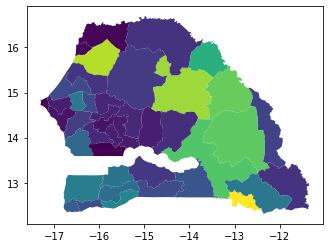

In [11]:
df_unit.plot("severity")

In [12]:
df_unit = gpd.GeoDataFrame.from_features(unit_dict)
df_unit = gpd.GeoDataFrame.from_features(unit_dict)
df_unit.columns = ['geometry', 'NAME', 'adm2_name_code']
df_unit.set_index('adm2_name_code', inplace=True)
for y in range(2013, 2020):
    df_y = ds.df_y.copy()
    df_y.reset_index(inplace=True)
    df_y =  df_y[df_y['season'] == y]
    df_y = df_y[['adm2_name_code', 'severity']]
    df_y.columns = ['adm2_name_code', f'severity_{y}']
    df_y['adm2_name_code'] = df_y['adm2_name_code'].astype(int)
    df_y.set_index('adm2_name_code', inplace=True)
    df_unit = df_unit.join(df_y)

### Simple dash app:

In [13]:
df_unit.head(1)

geometry  \
adm2_name_code                                                      
25              MULTIPOLYGON (((-16.63903 13.68070, -16.63903 ...   

                       NAME  severity_2013  severity_2014  severity_2015  \
adm2_name_code                                                             
25              Foundiougne       1.883139       1.562505       1.292488   

                severity_2016  severity_2017  severity_2018  severity_2019  
adm2_name_code                                                              
25                   1.382496       1.225001       1.165001       1.060001

In [16]:
with open(Path(root_folder).joinpath("mapbox_token.txt")) as f:
    token = f.read()

In [17]:
# index should be set to adm2_name_code
def display_choropleth(candidate):
    fig = px.choropleth_mapbox(df_unit,
                                geojson=df_unit.geometry,
                                locations=df_unit.index,
                                color=candidate,
                                center={"lat": 14.4097, "lon": -14.8635},
                                zoom=5.7,
                                # projection="mercator",
                                color_continuous_scale=["#CDFACD",
                                                        "#FAE61E",
                                                        "#E67800",
                                                        "#C80000",
                                                        "#1D1D1D"],
                                labels='NAME',
                                template='plotly', range_color=(1,3.5))
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox_accesstoken=token)
    return fig

fig = display_choropleth('severity_2013')
fig.show()

In [ ]:
# df_unit.sort_values('adm2_name_code')

In [18]:
ds = Dataset(root_folder=root_folder)
ds.prepare_dataset_array()
ds.df_y['severity'].max()


3.3438836519158595

In [73]:
ds.df_y

adm2_name  severity    phase1    phase2    phase3  \
season adm2_name_code                                                     
2013   0                      0  1.439991  0.720001  0.200000  0.079999   
       1                      1  1.399998  0.740002  0.189998  0.070000   
       2                      2  1.309990  0.790004  0.159999  0.049997   
       3                      3  2.210003  0.350000  0.449999  0.160000   
       4                      4  1.320012  0.799997  0.140001  0.060002   
...                         ...       ...       ...       ...       ...   
2019   1                      1  1.190002  0.850000  0.129999  0.020001   
       44                    44  1.360000  0.740000  0.210000  0.050000   
       15                    15  1.120000  0.880000  0.120000  0.000000   
       35                    35  1.280000  0.820000  0.130000  0.050000   
       31                    31  1.154998  0.865001  0.124999  0.009999   

                         phase4  phase5  sample  
season adm2_name_code                            
2013   0               0.000000     0.0       0  
       1               0.000000     0.0       1  
       2               0.000000     0.0       2  
       3               0.040001     0.0       3  
       4               0.000000     0.0       4  
...                         ...     ...     ...  
2019   1               0.000000     0.0     271  
       44              0.000000     0.0     314  
       15              0.000000     0.0     285  
       35              0.000000     0.0     305  
       31              0.000000     0.0     301  

[297 rows x 8 columns]

In [74]:
ds.df_x['variable'].unique()

array(['SPI - 3 months', 'Water Satisfaction Index (WSI)',
       'NDVI - zscore', 'NDVI', 'NDVI Cumulated - zscore', 'Temperature',
       'urbanization', 'Rainfall', 'Maize', 'Millet', 'Rice'],
      dtype=object)